# BINARY CLASSIFICATION

##### XGBoost model 
##### annotation result 0, 1 (binary classification)
##### 결측치 mean()
##### age, gender 제외한 모든 항목을 feature_importances에 따라 feature weights 부여
##### Imbalanced data로 인한 class weights 부여 

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('judge 제거_LCE.csv')

## Preprocessing
#### 1. annotation result = 3, Null drop

In [22]:
# annotation result = 0, 1, 2 만 남기고 확인 

null_annot = list(np.where(df['annotation_result'].isna() == True)[0])
df = df.drop(null_annot, axis = 'index')
df.index = range(len(df))

three_annot = list(np.where(df['annotation_result'] == 3)[0])
df = df.drop(three_annot, axis = 'index')
df.index = range(len(df))

df['annotation_result'].unique()

array([1., 0., 2.])

In [23]:
zero = list(np.where(df['annotation_result'] == 0)[0])
one = list(np.where(df['annotation_result'] == 1)[0])
two = list(np.where(df['annotation_result'] == 2)[0])
df['annotation_result'][zero] = 0
df['annotation_result'][one] = 0
df['annotation_result'][two] = 1

df['annotation_result'].unique()

array([0., 1.])

## 결측치 mean(), train, test split

In [54]:
df = df.fillna(df.mean())

#최빈값
#df = df.fillna(df.mode().iloc[0])
#df

#중앙값
#df = df.fillna(df.median().iloc[0])
#df

In [25]:
# Select all columns except certain columns
X = df.iloc[:,7:]
y = np.ravel(df.loc[:, ['annotation_result']])

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Training set:  (1427, 72) (1427,)
Test set:  (357, 72) (357,)


## Scaler 적용 

In [26]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)


# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

# Machine Learning Model

[09:47:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "feature_weights" } are not used.

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87       404
         1.0       0.60      0.64      0.62       132

    accuracy                           0.80       536
   macro avg       0.74      0.75      0.74       536
weighted avg       0.81      0.80      0.81       536



<AxesSubplot:>

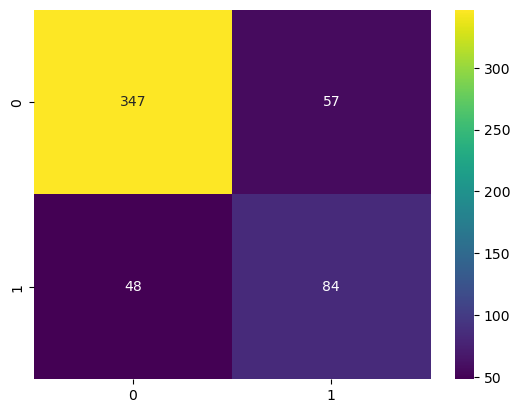

In [46]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split


# feature 중요도 계산
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X, y)
feature_importance = model.feature_importances_

# feature 가중치 설정
feature_weights = feature_importance / np.sum(feature_importance)

# 클래스 가중치
pos_weight = len(y[y==0])/len(y[y==1])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 훈련
params = {'objective': 'binary:logistic', 'eval_metric': 'error', 
          'feature_weights': feature_weights, 'scale_pos_weight': pos_weight}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(params, dtrain, num_boost_round=10)

# 테스트 데이터 예측
y_pred = model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

# classification report 출력
print(classification_report(y_test, y_pred))

# confusion matrix 출력
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap='viridis')

## feature importances 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

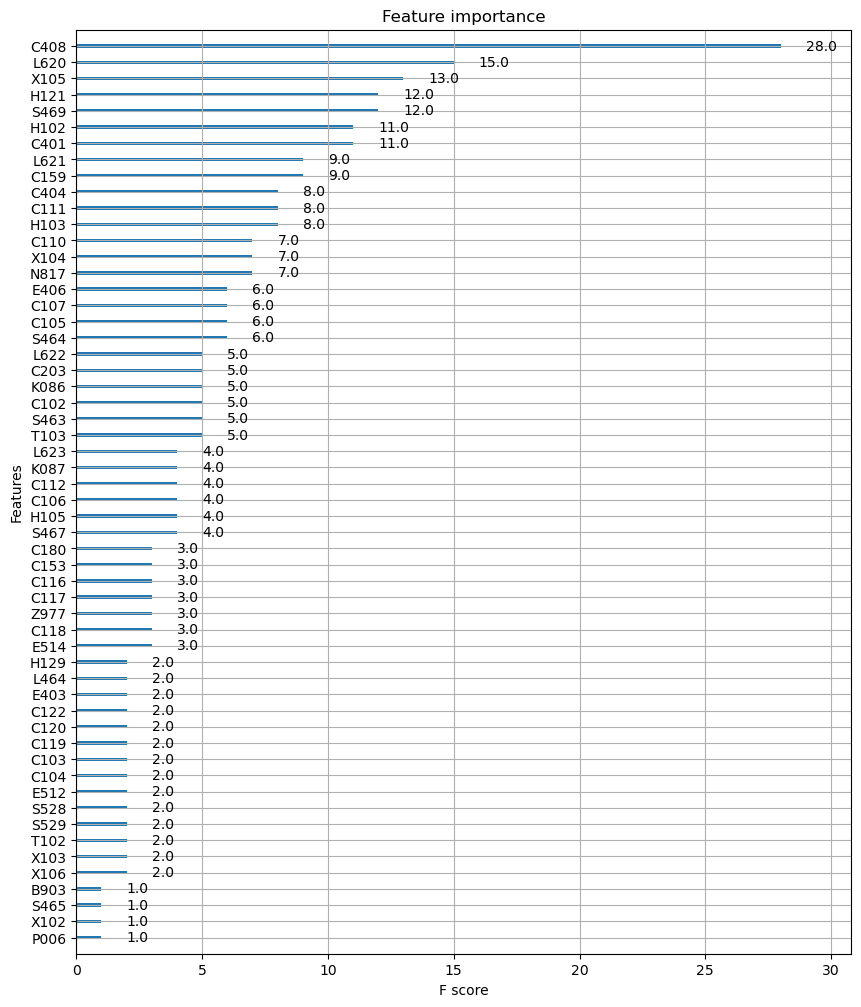

In [50]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax = ax)